# MAE 271: Lab 2 - Inverted pendulum with vertical base excitation
### Cooper Cook & Joshua Booth

## Introduction

## Code and figures

### Global Parameters
Define global parameters and initial conditions for the system:

In [16]:
import numpy as np

# -----------------------------
# Global Parameters
# -----------------------------
params: dict[str, float] = {}
params["l_arm"] = 1.0   # length of pendulum arm [m]
params["m_mass"] = 1.0  # mass of pendulum mass [kg]
params["g"] = 9.8       # gravitational force [m/s^2]

params["theta"] = 0     # initial pendulum angle [rad]
params["amplitude"] = 0 # oscillator amplitude [m]
params["frequency"] = 0 # oscillator frequency [Hz]

# Time
t_start: float = 0
t_end: float = 1
t_increment: float = 0.001

t_span = (t_start, t_end)
t_eval = np.arange(min(t_span), max(t_span)+t_increment, t_increment)

### Derivative Function
To solve this non-linear system of ordinary differential equations, we need to start from an initial state, numerically integrate along the state derivatives to find the next state, and repeat as desired

For integration, we will use `scipy.integrate`'s `solve_ivp()`, which takes in a range of time (`t_span`) through which to integrate, a function handle (`func`) that takes in the time and state and returns the derivatives, and the initial condition (`initial`) of the state.

Since we wish to solve this problem using several different parameters, we will define a function `get_func()` that returns a function handle that we can pass to `solve_ivp()`.

In [17]:
from copy import deepcopy

def get_func(params: dict[str, float]):
    # Make a copy of the input parameters to ensure the returned function 
    # does not change when the original parameters dictionary changes
    params = deepcopy(params)

    # Extract parameters from dict
    theta = params["theta"]
    ampl: float = params["amplitude"]
    freq: float = params["frequency"]
    leng: float = params["l_arm"]
    mass: float = params["m_mass"]
    g: float = params["g"]

    # Create array to contain all the resolved states
    states: list[dict[str, float]] = []

    # Get initial condition
    x0 = leng*np.sin(theta)
    y0 = leng*np.cos(theta)
    px = 0
    initial = [x0, y0, px, theta]

    # Create derivative calculator function to be used by solve_ivp()
    # state = [px, theta]
    def func(t, state):
        x = state[0]
        y = state[1]
        px = state[2]
        theta = state[3]

        # Sine and cosine of theta, for computational speed
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        tan_theta = sin_theta/cos_theta

        if cos_theta == 0:
            print("this sucks")

        # y-position of cart and its derivatives
        Y = ampl*np.sin(freq*t)
        d_Y = ampl*freq*np.cos(freq*t)
        dd_Y = -(freq**2)*Y

        # Other momentum
        py = mass*(d_Y - tan_theta*px/mass)

        # State derivatives
        d_theta = px/(leng*cos_theta*mass)
        d_px = mass*g*sin_theta*cos_theta + mass*dd_Y*sin_theta*cos_theta - tan_theta*d_theta*px
        d_py = mass*(dd_Y - tan_theta*d_px/mass - px*d_theta/(mass*cos_theta**2))
        
        # Concatenate vars
        d_state = [px/mass, py/mass, d_px, d_theta]

        # Add current state to states dict
        state = {}
        state["t"] = t
        state["Y"] = Y
        state["x"] = x
        state["y"] = y
        state["px"] = px
        state["py"] = py
        state["theta"] = theta
        state["d_Y"] = d_Y
        state["d_px"] = d_px
        state["d_py"] = d_py
        state["d_theta"] = d_theta
        state["dd_Y"] = dd_Y

        states.append(state)

        return d_state

    return func, states, initial

### Integrate and Plot Data

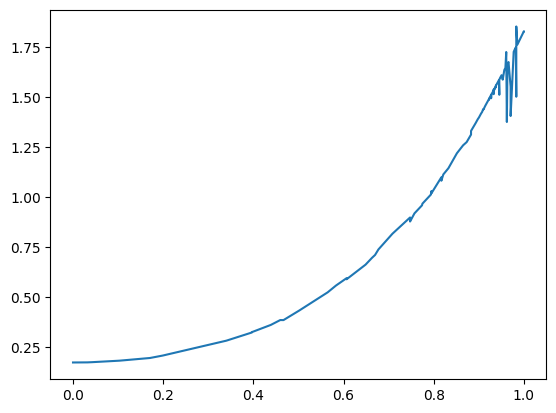

In [19]:
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

params["amplitude"] = 0
params["theta"] = np.deg2rad(10)
func, states, initial = get_func(params)
sol = solve_ivp(func, t_span, initial, t_eval=t_eval)

df = pd.DataFrame(states).sort_values("t")

t_vals = df.get("t").to_numpy()
X_vals = np.zeros_like(t_vals)
Y_vals = df.get("Y").to_numpy()
x_vals = df.get("x").to_numpy()
y_vals = df.get("y").to_numpy()
px_vals = df.get("px").to_numpy()
py_vals = df.get("py").to_numpy()
theta_vals = df.get("theta").to_numpy()

num_frames = len(t_vals)
theta_fig = plt.figure()
theta_ax = theta_fig.add_subplot()
theta_ax.plot(t_vals, theta_vals)

fig = plt.figure()
ax = fig.add_subplot()

cart, = ax.plot([], [], 'o', c='k')
pend, = ax.plot([], [], 'o', c='b')

def update_points(n):
    cart.set_data(([X_vals[n]], [Y_vals[n]]))
    pend.set_data(([x_vals[n]], [y_vals[n]]))
    return cart, pend

ani = animation.FuncAnimation(fig, update_points, num_frames, interval=10)
plt.close()

all_x = np.concatenate((X_vals.copy(), px_vals.copy()))
all_y = np.concatenate((Y_vals.copy(), py_vals.copy()))
min_x, max_x = min(all_x), max(all_x)
min_y, max_y = min(all_y), max(all_y)
ax.set_xlim([min_x-0.5, max_x+0.5])
ax.set_ylim([min_y-0.5, max_y+0.5])

from IPython.display import HTML
HTML(ani.to_jshtml())